### A Quantitative Test for SARS-CoV-2 Infection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Read Data Matrix

In [3]:
ori_TPM = pd.read_csv("C:\\Users\\xuzef\\Desktop\\dataset2\\TPM_S1G.txt", sep='\t', header=0, index_col=0)
gene_id = list(ori_TPM.index)
gene_symbol = ori_TPM.iloc[:,0].to_numpy().flatten()
ori_TPM = ori_TPM.drop(['Symbol'], axis=1)
all_TPM = ori_TPM

names = list(all_TPM.columns)
remove = ["H1_H","H2_H","H3_H","H4_H","H6_H","H7_H","H8_H","H9_H"]          # all healthy patients removed (only have 1 timepoint)
special = ["43_D7A", "43_D7B", "87_D3A", "87_D3B", "154_D7A", "154_D7B", "302_DEA", "302_DEB", "321_D7A", "321_D7B"]
for n in names:
    if n in special:                               # these special timepoints need to be processed separately
        continue
    if "DE" in n:
        remove.append(n)                           # all DE timepoints removed

# At some timepoints, some patients may have A and B data, we decide to take the average and merge them into one
# 43_D7, 87_D3, 154_D7, 302_DE, 321_D7 are such patients and timepoints
remove.extend(special)
all_TPM.loc[:,"43_D7"] = (all_TPM.loc[:,"43_D7A"]+all_TPM.loc[:,"43_D7B"])/2
all_TPM.loc[:,"87_D3"] = (all_TPM.loc[:,"87_D3A"]+all_TPM.loc[:,"87_D3B"])/2
all_TPM.loc[:,"154_D7"] = (all_TPM.loc[:,"154_D7A"]+all_TPM.loc[:,"154_D7B"])/2
all_TPM.loc[:,"321_D7"] = (all_TPM.loc[:,"321_D7A"]+all_TPM.loc[:,"321_D7B"])/2
all_TPM = all_TPM.drop(list(set(remove)), axis=1)

# Imputation
names = list(all_TPM.columns)
for i in range(1,387):                      # patient id range from 1 to 386
    if i in [141,142,183,202,269,270]:      # we do not have any data for these patients so skip
        continue
    temp = []
    for n in names:
        if len(temp) == 3:
            break
        if f"{i}_D" in n and len(n) == int(np.log10(i))+4:
            temp.append(n)

    if len(temp) == 3:          # if located all D0, D3 and D7 data, then this patient's data is complete, continue
        continue

    D0_in = ["_D0" in i for i in temp]
    D3_in = ["_D3" in i for i in temp]
    D7_in = ["_D7" in i for i in temp]
    if not any(D3_in):
        if any(D0_in) and any(D7_in):
            all_TPM.loc[:,f"{i}_D3"] = (all_TPM.loc[:, f"{i}_D0"]+all_TPM.loc[:, f"{i}_D7"])/2      # if D0&D7 present but not D3, then D3 = (D0+D7)/2
        elif any(D0_in):
            all_TPM.loc[:,f"{i}_D3"] = all_TPM.loc[:, f"{i}_D0"]
            all_TPM.loc[:,f"{i}_D7"] = all_TPM.loc[:, f"{i}_D0"]        # if only D0 present, then both D3&D7 = D0
        elif any(D7_in):
            all_TPM.loc[:,f"{i}_D3"] = all_TPM.loc[:, f"{i}_D7"]
            all_TPM.loc[:,f"{i}_D0"] = all_TPM.loc[:, f"{i}_D7"]        # if only D7 present, then both D0&D3 = D7
    else:
        if not any(D0_in):
            all_TPM.loc[:,f"{i}_D0"] = all_TPM.loc[:, f"{i}_D3"]        # if D3 present but not D0, then D0 = D3
        if not any(D7_in):
            all_TPM.loc[:,f"{i}_D7"] = all_TPM.loc[:, f"{i}_D3"]        # if D3 present but not D7, then D7 = D3

mean_sum = all_TPM.sum(axis=0).to_numpy().flatten().mean()
for col in all_TPM.columns:
    all_TPM.loc[:,col] /= np.sum(all_TPM.loc[:,col])                # normalize
    all_TPM.loc[:,col] *= mean_sum
    all_TPM.loc[:,col] = np.log2(all_TPM.loc[:,col]+1)              # +1 & log2

all_TPM = all_TPM.T
print(all_TPM.shape)

new_index = []
for i in range(1,387):
    if i in [141,142,183,202,269,270]:
        continue
    else:
        new_index.extend([f"{i}_D0", f"{i}_D3", f"{i}_D7"])
all_TPM = all_TPM.loc[new_index,:]

(1140, 60640)


Read Labels

In [4]:
labels_data = pd.read_csv("C:\\Users\\xuzef\\Desktop\\dataset2\\labels.csv", sep=',', encoding='UTF-8', header=0, index_col=0)
acuity_labels = labels_data.iloc[:,1]
covid_labels = labels_data.iloc[:,0]

In [5]:
labels_map = {0:0, 1:0}
for c in covid_labels.to_numpy():
    labels_map[c] += 1
print(labels_map)

acuity_maps = {1:0, 2:0, 3:0, 4:0, 5:0}
for a in acuity_labels.to_numpy():
    acuity_maps[a] += 1
print(acuity_maps)

{0: 228, 1: 912}
{1: 141, 2: 246, 3: 504, 4: 156, 5: 93}


Figure 1: All positive <br>
Since there are too many data, we only show the positive/negative value distribution for the first 100 columns for simplicity, which already means 78,100 data points to show.

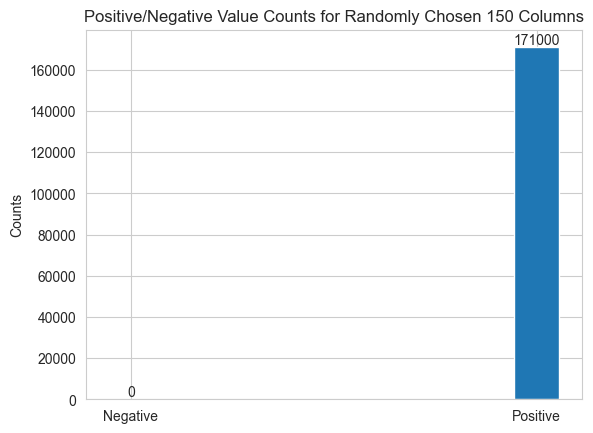

In [21]:
chosen = np.random.randint(0, all_TPM.shape[1], 150)
partial = all_TPM.iloc[:, chosen]

all_positive = []
for i in range(partial.shape[0]):
    for j in range(partial.shape[1]):
        if partial.iloc[i, j] >= 0:
            all_positive.append(1)
        else:
            all_positive.append(0)
counts, edges, bars = plt.hist(all_positive, range=range(2))
plt.bar_label(bars, labels=[int(bars[0].get_height()), '', '', '', '', '', '', '', '', int(bars[9].get_height())])
plt.xticks([0.05, 0.95], ["Negative", "Positive"])
plt.ylabel("Counts")
plt.title("Positive/Negative Value Counts for Randomly Chosen 150 Columns")
plt.show()

Figure 2: Missing Data - Distribution of missing data points vs. acuity labels

In [7]:
def get_missing(patient, all_samples):
    missing = []
    if f'{p}_D0' not in all_sample_names:
        missing.append(0)
    if f'{p}_D3' not in all_sample_names:
        missing.append(3)
    if f'{p}_D7' not in all_sample_names:
        missing.append(7)
    
    return missing

def get_label(patient, all_samples, acuity):
    if f'{p}_D0' in all_sample_names:
        return acuity.loc[f'{p}_D0']
    elif f'{p}_D3' in all_sample_names:
        return acuity.loc[f'{p}_D3']
    elif f'{p}_D7' in all_sample_names:
        return acuity.loc[f'{p}_D7']
    else:
        return -1

After removing all DE time points, 1140 samples remain.


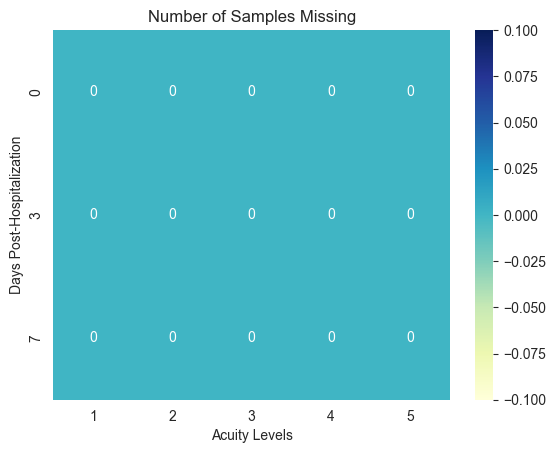

In [8]:
all_sample_names = list(all_TPM.index)
DE_removed = []
for n in all_sample_names:
    if 'DE' not in n:
        DE_removed.append(n)
    else:
        print(n)
print(f"After removing all DE time points, {len(DE_removed)} samples remain.")

missing_samples = {}
for p in range(1, 387):         # ID ranges from 1 to 386
    miss = get_missing(p, DE_removed)
    if len(miss) != 3:
        missing_samples[p] = miss

acuity_map = {}
for p in range(1, 387):
    l = get_label(p, DE_removed, acuity_labels)
    if l != -1:
        acuity_map[p] = l

# for p in list(missing_samples.keys()):
#     if acuity_map[p] == 4 or acuity_map[p] == 5:
#         print(acuity_map[p], missing_samples[p])

missing_map_acuity = {1:{0:0, 3:0, 7:0}, 2:{0:0, 3:0, 7:0}, 3:{0:0, 3:0, 7:0}, 4:{0:0, 3:0, 7:0}, 5:{0:0, 3:0, 7:0}}
acuity_level_count = {1:0, 2:0, 3:0, 4:0, 5:0}
for p in list(missing_samples.keys()):
    acuity_level = acuity_map[p]
    for s in missing_samples[p]:
        missing_map_acuity[acuity_level][s] += 1

df = pd.DataFrame(missing_map_acuity)
import seaborn as sns
sns.heatmap(df, annot=df, fmt='g', cmap='YlGnBu')
plt.xlabel("Acuity Levels")
plt.ylabel("Days Post-Hospitalization")
plt.title("Number of Samples Missing")
plt.show()

Figures 3,4,5,6: Min/Max/Mean/Std of each column

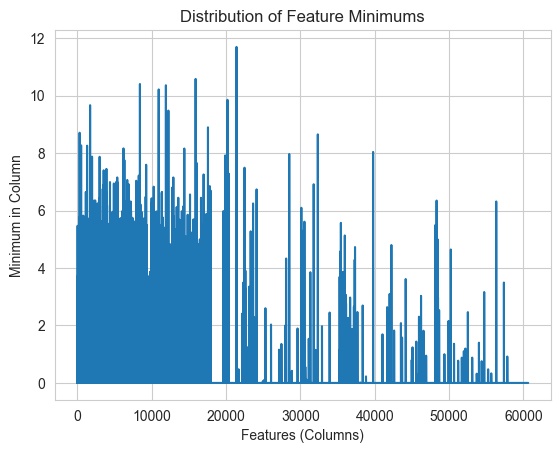

In [9]:
mins = all_TPM.min()
plt.plot(range(len(mins)), mins)
plt.xlabel("Features (Columns)")
plt.ylabel("Minimum in Column")
plt.title("Distribution of Feature Minimums")
plt.show()

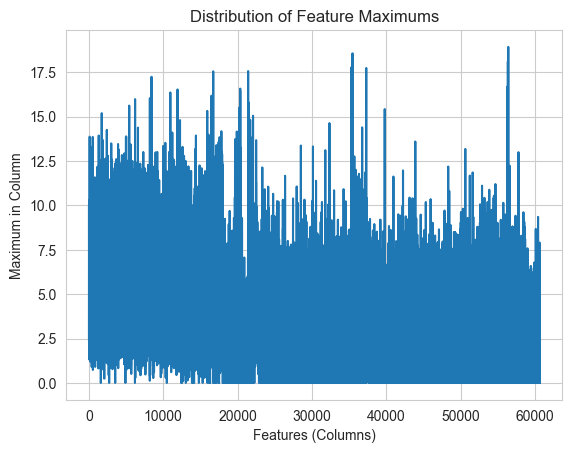

In [10]:
maxs = all_TPM.max()
plt.plot(range(len(maxs)), maxs)
plt.xlabel("Features (Columns)")
plt.ylabel("Maximum in Column")
plt.title("Distribution of Feature Maximums")
plt.show()

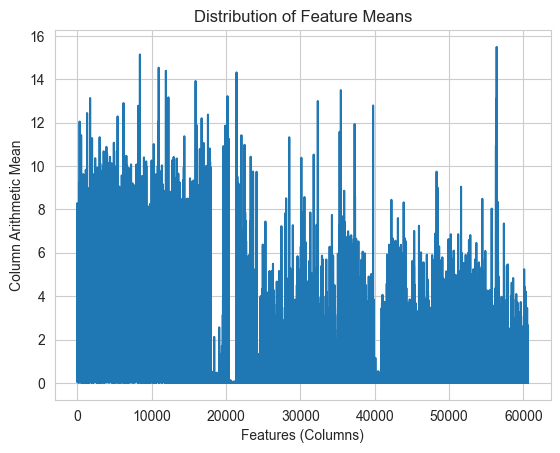

In [11]:
means = all_TPM.mean()
plt.plot(range(len(means)), means)
plt.xlabel("Features (Columns)")
plt.ylabel("Column Arithmetic Mean")
plt.title("Distribution of Feature Means")
plt.show()

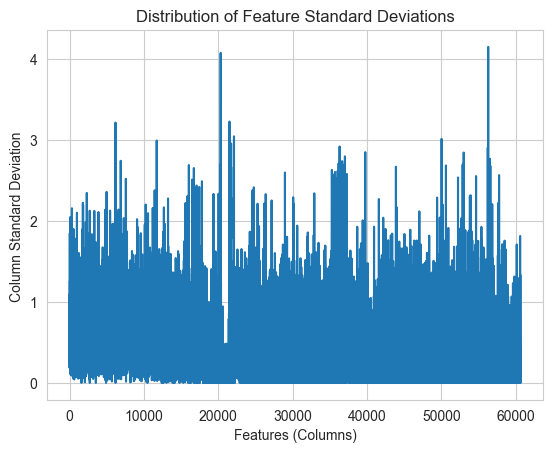

In [12]:
stds = all_TPM.std()
plt.plot(range(len(stds)), stds)
plt.xlabel("Features (Columns)")
plt.ylabel("Column Standard Deviation ")
plt.title("Distribution of Feature Standard Deviations")
plt.show()

Figure 7: Acuity & Target

{1: {0: 21, 1: 120}, 2: {0: 45, 1: 201}, 3: {0: 105, 1: 399}, 4: {0: 33, 1: 123}, 5: {0: 24, 1: 69}}


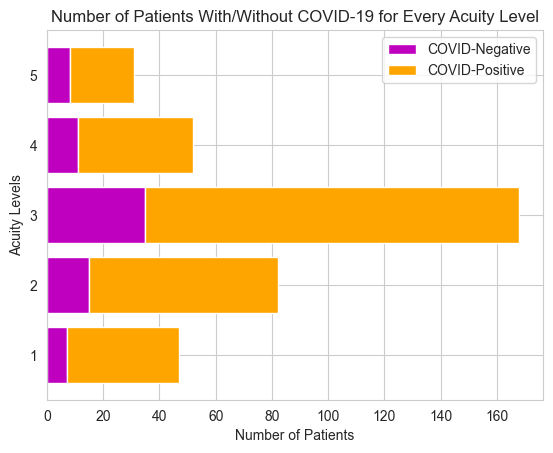

In [13]:
acuity_covid = {1:{0:0, 1:0}, 2:{0:0, 1:0}, 3:{0:0, 1:0}, 4:{0:0, 1:0}, 5:{0:0, 1:0},}
a_label = acuity_labels.to_numpy()
c_label = covid_labels.to_numpy()
for i in range(len(a_label)):
    acuity_covid[a_label[i]][c_label[i]] += 1
print(acuity_covid)

x = [1, 2, 3, 4, 5]
y1 = []
y2 = []
for a, v in acuity_covid.items():
    y1.append(v[0])
    y2.append(v[1])
for i in range(len(y1)):
    y1[i] = int(y1[i]/3)
    y2[i] = int(y2[i]/3)

plt.barh(x, y1, color='m')
plt.barh(x, y2, left=y1, color='orange')
plt.legend(['COVID-Negative', 'COVID-Positive'])
plt.xlabel("Number of Patients")
plt.ylabel("Acuity Levels")
plt.title("Number of Patients With/Without COVID-19 for Every Acuity Level")
plt.show()

Splitting

In [14]:
def full_samples(indices):
    all_samples = []
    for p_id in indices:
        all_samples.extend([f"{p_id}_D0", f"{p_id}_D3", f"{p_id}_D7"])
    return all_samples

In [15]:
from sklearn.model_selection import train_test_split

all_patient_ids = []
for i in range(1, 387):
    if i not in [141,142,183,202,269,270]:
        all_patient_ids.append(i)

divided_covid_labels = np.split(covid_labels.to_numpy(), 380)
all_patient_labels = []
for p_labels in divided_covid_labels:
    all_patient_labels.append(p_labels[0])

other_x, test_x, other_y, test_y = train_test_split(all_patient_ids, all_patient_labels, train_size=0.8, test_size=0.2, stratify=all_patient_labels)
train_x, val_x, train_y, val_y = train_test_split(other_x, other_y, train_size=0.75, test_size=0.25, stratify=other_y)

all_train = full_samples(train_x)
all_val = full_samples(val_x)
all_test = full_samples(test_x)

X_train, y_train = all_TPM.loc[all_train, :], covid_labels[all_train]
X_val, y_val = all_TPM.loc[all_val, :], covid_labels[all_val]
X_test, y_test = all_TPM.loc[all_test, :], covid_labels[all_test]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(684, 60640)
(228, 60640)
(228, 60640)


In [16]:
print(pd.DataFrame(covid_labels).value_counts())

status
1         912
0         228
Name: count, dtype: int64


In [17]:
print(pd.DataFrame(y_train).value_counts())

status
1         546
0         138
Name: count, dtype: int64


In [18]:
print(pd.DataFrame(y_val).value_counts())

status
1         183
0          45
Name: count, dtype: int64


In [19]:
print(pd.DataFrame(y_test).value_counts())

status
1         183
0          45
Name: count, dtype: int64
